# spynal tutorial

In [1]:
# Standard PyData imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("Imports successful")

Imports successful


In [2]:
### Data loading from mat file using matIO module ###
from spynal.matIO import loadmat

filename = r'./example_WM_data.mat'

# Load some data from a mat file into Python variables. Load 'trialInfo' as a Pandas DataFrame
trial_info, spike_times, lfp, lfp_timepts = \
    loadmat(filename, variables=['trialInfo','spikeTimes','lfp','lfp_timepts'],
            typemap={'trialInfo':'DataFrame'}, verbose=True)

# Alternatively, we could load all variables into a Python dictionary (similar to Matlab struct) 
# with variable names as keys (fields)
data = loadmat(filename, variables=['trialInfo','spikeTimes','lfp','lfp_timepts'], asdict=True, verbose=False)

trialInfo : pandas.DataFrame with columns[fixationTime,responseTime,sample,sampleOff,sampleOn,testOn,]

spikeTimes : numpy.array( 40,  2,) of type object

lfp : numpy.array(5001,  2, 40,) of type float64

lfp_timepts : numpy.array(5001,) of type float64



In [3]:
### Spiking data analysis using spikes module ###
from spynal.spikes import times_to_bool, rate

# Compute spike rate in 50 ms bins (10 ms step) from -0.5 to 2.5 s
# Can also set custom bins (bins=<bins>) or return spike counts (count=True)
spike_rate, rate_bins = rate(spike_times, method='bin', lims=[-0.5,2.5], width=50e-3, step=10e-3)
rate_bin_centers = np.mean(rate_bins, axis=1)
print("Binned spike rate (trials,units,time bins): ", spike_rate.shape)

# Compute spike density with 50 ms Gaussian kernel and downsample to 100 Hz (10 ms)
spike_density, timepts = rate(spike_times, method='density', lims=[-0.5,2.5], kernel='gaussian', width=50e-3,
                              step=10e-3)
print("Spike density (trials,units,timepoints): ", spike_density.shape)

# If you prefer working with binary (1/0) spike data, you could also do this
# spike_bool, timepts = times_to_bool(spike_times, lims=[-0.5,2.5])
# spike_density, timepts = rate(spike_bool, method='density', kernel='gaussian', width=50e-3, 
#                               t=timepts, downsmp=10, axis=-1)

Binned spike rate (trials,units,time bins):  (40, 2, 296)
Spike density (trials,units,timepoints):  (40, 2, 301)


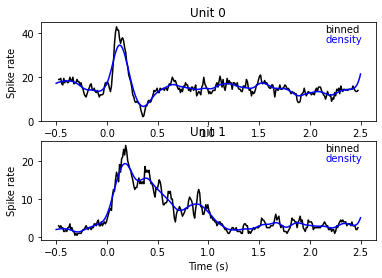

In [4]:
# Plot mean +/- SEM spike rate across trials (axis 0) for each single unit (unit 1)
# Note: transform=plt.gca().transAxes makes text appear at normalized (0-1),
#       rather than at location specified by plot axes
plt.figure()
for unit in range(2):
    plt.subplot(2,1,unit+1) # Note: Subplots are numbered 1 - n_subplots
    plt.plot(rate_bin_centers, np.mean(spike_rate[:,unit,:], axis=0), color='k')
    plt.plot(timepts, np.mean(spike_density[:,unit,:], axis=0), color='b')    
    plt.text(0.85, 0.9, 'binned', color='k', transform=plt.gca().transAxes)
    plt.text(0.85, 0.8, 'density', color='b', transform=plt.gca().transAxes)
    plt.title("Unit %d" % unit)
    plt.xlabel('Time (s)')
    plt.ylabel('Spike rate')

In [5]:
### Spectral analysis using spectra module ###
from spynal.spectra import remove_evoked, spectrogram, pool_freq_bands, one_over_f_norm

# Remove evoked potentials from LFP data (separately for each sample object condition)
lfp = remove_evoked(lfp, axis=-1, method='mean', design=trial_info['sample'])

# Compute wavelet power spectrogram for each electrode (with logarithmic frequency sampling)
spec_wave, f_wave, t_wave = spectrogram(lfp, smp_rate=1000, axis=0, method='wavelet', spec_type='power',
                                        freqs=2**np.arange(1,7,0.2), downsmp=10)
print("Wavelet spectrogram (frequency,time,electrodes,trials): ", spec_wave.shape)

# Compute multitaper power spectrogram (sampling from 2-100 Hz, with 0.5 s time, 4 Hz freq bandwidth)
spec_mt, f_mt, t_mt = spectrogram(lfp, smp_rate=1000, axis=0, method='multitaper', spec_type='power',
                                  freq_range=[2,100], time_width=0.5, freq_width=4, n_tapers=3, spacing=0.1)
print("Multitaper spectrogram (frequency,time,electrodes,trials): ", spec_mt.shape)

# spectrogram returns time sampling referenced to start of input data. Convert to actual times.
t_wave += lfp_timepts[0]
t_mt += lfp_timepts[0]

# Normalize time-frequency data to correct for 1/f baseline distribution of power
spec_wave   = one_over_f_norm(spec_wave, axis=0, freqs=f_wave)
spec_mt     = one_over_f_norm(spec_mt, axis=0, freqs=f_mt)

# Pool wavelet and multitaper spectrograms by frequency band (theta, beta, and gamma)
band_names = ['theta','beta','gamma']
bands = np.asarray([[3,8],[12,30],[40,80]])
spec_wave_band = pool_freq_bands(spec_wave, bands, axis=0, freqs=f_wave)
spec_mt_band = pool_freq_bands(spec_mt, bands, axis=0, freqs=f_mt)

print("Wavelet band-pooled (frequency bands,time,electrodes,trials): ", spec_wave_band.shape)
print("Multitaper band-pooled (frequency bands,time,electrodes,trials): ", spec_mt_band.shape)

Wavelet spectrogram (frequency,time,electrodes,trials):  (30, 501, 2, 40)
Multitaper spectrogram (frequency,time,electrodes,trials):  (50, 46, 2, 40)
Wavelet band-pooled (frequency bands,time,electrodes,trials):  (3, 501, 2, 40)
Multitaper band-pooled (frequency bands,time,electrodes,trials):  (3, 46, 2, 40)


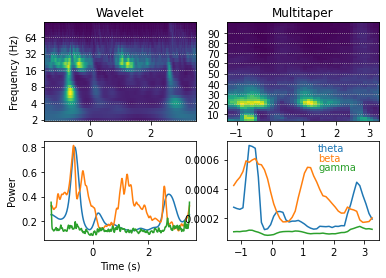

In [6]:
from spynal.spectra import plot_spectrogram

# Plot spectrograms averaged across trials (axis 3) and electrodes (axis 2)
plt.figure()
plt.subplot(2,2,1)
plot_spectrogram(t_wave, f_wave, np.mean(spec_wave,axis=(2,3)))
plt.title('Wavelet')
plt.ylabel('Frequency (Hz)')

plt.subplot(2,2,2)
plot_spectrogram(t_mt, f_mt, np.mean(spec_mt,axis=(2,3)))
plt.title('Multitaper')

plt.subplot(2,2,3)
# Note: Selecting one freq band reduced spec_xxx_band variable to (time,electrodes,trials), 
# so electrodes is now axis 1 and trials axis 2
for i_band in range(3):
    # Note: colors 'C0','C1',... reference the standard plotting colors in matplotlib
    plt.plot(t_wave, np.mean(spec_wave_band[i_band,:,:,:],axis=(1,2)), '-', color='C%d'%i_band)
plt.xlabel('Time (s)')
plt.ylabel('Power')

ax = plt.subplot(2,2,4)
for i_band in range(3):
    plt.plot(t_mt, np.mean(spec_mt_band[i_band,:,:,:],axis=(1,2)), '-', color='C%d'%i_band)
    plt.text(0.6, 0.9-i_band*0.1, band_names[i_band], color='C%d'%i_band, transform=ax.transAxes)

In [7]:
### Synchrony analysis using sync module ###
from spynal.sync import synchrony

# Compute multitaper-based coherence between 1st and 2nd electrodes
# Note: keepdims=False argument tells function to squeeze out singleton trial and taper axes
coh, f_coh, t_coh = synchrony(lfp[:,0,:], lfp[:,1,:], axis=-1, method='coherence', spec_method='multitaper',
                              smp_rate=1000, time_axis=0, freq_range=[2,100], spacing=0.1, keepdims=False)
print("Coherence (frequency,time): ", coh.shape)

# Compute wavelet-based pairwise phase consistency between 1st and 2nd electrodes
ppc, f_ppc, t_ppc = synchrony(lfp[:,0,:], lfp[:,1,:], axis=-1, method='ppc', spec_method='wavelet',
                              smp_rate=1000, time_axis=0, freqs=2**np.arange(1,7,0.2), downsmp=10, keepdims=False)
print("PPC (frequency,time): ", ppc.shape)

t_coh += lfp_timepts[0]
t_ppc += lfp_timepts[0]

# Alternatively, you could pre-compute complex-valued spectrograms, and input those to synchrony()
# spec_wave, f_wave, t_wave = spectrogram(lfp[:,0:2,:], smp_rate=1000, axis=0, method='wavelet', spec_type='complex',
#                                         freqs=2**np.arange(1,7,0.2), downsmp=10)
# ppc, _, _ = synchrony(spec_wave[:,:,0,:], spec_wave[:,:,1,:], axis=-1, method='ppc')

Coherence (frequency,time):  (50, 46)
PPC (frequency,time):  (30, 501)


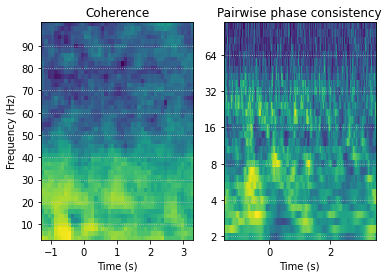

In [8]:
# Plot time-frequency synchrony
plt.figure()

plt.subplot(1,2,1)
plot_spectrogram(t_coh, f_coh, coh)
plt.title('Coherence')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')

plt.subplot(1,2,2)
plot_spectrogram(t_ppc, f_ppc, ppc)
plt.title('Pairwise phase consistency')
plt.xlabel('Time (s)');

In [9]:
### Information analysis using info module ###
from spynal.info import neural_info

labels = trial_info['sample']

# Compute neural information about sample object in spike rates using population decoding (classification)
# Note: Info functions return trial axis as singleton for consistency with multi-factor designs and with input data
accuracy = neural_info(spike_rate, labels, axis=0, feature_axis=1, method='decode')
print("Accuracy (1,1,time): ", accuracy.shape)

# # Compute neural information about sample object in spike rates using percent explained variance
# # Note: Info functions return trial axis as singleton for consistency with multi-factor designs and with input data
# pev = neural_info(spike_rate, labels, axis=0, method='pev', model='anova1')
# print("PEV (1,units,time): ", pev.shape)

# Alternatively, compute neural information about sample object using Shannon mutual information
mut_info = neural_info(spike_rate, labels, axis=0, method='mutual_information')
print("Mutual information (1,units,time): ", mut_info.shape)

Accuracy (1,1,time):  (1, 1, 296)
Mutual information (1,units,time):  (1, 2, 296)


Text(0.5, 0, 'Time (s)')

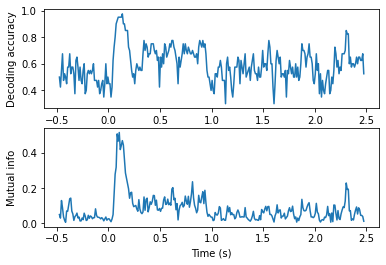

In [10]:
# Plot neural information for each method
plt.figure()
plt.subplot(2,1,1)
plt.plot(rate_bin_centers, np.squeeze(accuracy))   # Squeeze out singleton axes
plt.ylabel('Decoding accuracy')
plt.xlabel('Time (s)')

plt.subplot(2,1,2)
plt.plot(rate_bin_centers, np.squeeze(np.mean(mut_info,axis=1)))  # Compute mean across units
plt.ylabel('Mutual info')
plt.xlabel('Time (s)')

In [11]:
### Error estimation and significance tests using randstats ###
from spynal.randstats import paired_sample_test, one_way_test, one_sample_confints

# Paired-sample permutation test of difference in overall mean rate during stimulus vs baseline using t-statistic 
# (nonparametric analog of paired-sample t-test)
base_bool = (rate_bin_centers > -500e-3) & (rate_bin_centers <= 0)
smp_bool = (rate_bin_centers > 0) & (rate_bin_centers <= 500e-3)
p_mean, t_obs, t_shuf = paired_sample_test(np.mean(spike_rate[:,:,smp_bool],2), np.mean(spike_rate[:,:,base_bool],2),
                                           axis=0, method='permutation', stat='t', tail='both', return_stats=True)
print("p(sample vs baseline) (1,units): ", p_mean.shape)
print("t(sample vs baseline) (1,units): ", t_obs.shape)
print("t_shuffle(sample vs baseline) (resamples,units): ", t_shuf.shape)

# One-way permutation test of difference in mean rate between stimulus conditions using F-statistic
# (nonparametric analog of 1-way ANOVA F-test). Note: For 2 conditions, we could've also just used two_sample_test().
p_cond, F_obs, F_shuf = one_way_test(np.mean(spike_rate[:,:,base_bool],2), labels, axis=0, method='permutation',
                                           stat='F', tail='right', return_stats=True)
print("p(sample condition) (1,units): ", p_cond.shape)
print("F(sample condition) (1,units): ", F_obs.shape)
print("F_shuffle(sample condition) (resamples,units): ", F_shuf.shape)

# Bootstrap 95% confidence intervals on mean rate
rate_confints = one_sample_confints(spike_rate, axis=0, stat='mean', confint=0.95, return_stats=False)
print("confints(mean rate) (2=[lower,upper],units): ", rate_confints.shape)


p(sample vs baseline) (1,units):  (1, 2)
t(sample vs baseline) (1,units):  (1, 2)
t_shuffle(sample vs baseline) (resamples,units):  (9999, 2)
p(sample condition) (1,units):  (1, 2)
F(sample condition) (1,units):  (1, 2)
F_shuffle(sample condition) (resamples,units):  (9999, 2)
confints(mean rate) (2=[lower,upper],units):  (2, 2, 296)


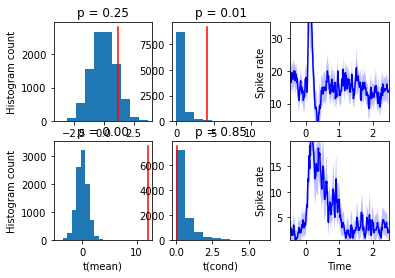

In [12]:
from spynal.plots import plot_line_with_error_fill

# Plot results of randomization tests/stats for each unit
plt.figure()

for unit in range(2):
    plt.subplot(2,3,unit*3+1)
    plt.hist(t_shuf[:,unit])                               # Histogram of shuffled stat values
    plt.plot([t_obs[0,unit],t_obs[0,unit]], plt.ylim(), 'r-')   # Line showing stat value for actual data
    plt.title("p = %.2f" % p_mean[0,unit])
    plt.ylabel("Histogram count")
    if unit == 1: plt.xlabel("t(mean)")

    plt.subplot(2,3,unit*3+2)
    plt.hist(F_shuf[:,unit])                               # Histogram of shuffled stat values
    plt.plot([F_obs[0,unit],F_obs[0,unit]], plt.ylim(), 'r-') # Line showing stat value for actual data
    plt.title("p = %.2f" % p_cond[0,unit])
    if unit == 1: plt.xlabel("t(cond)")

    plt.subplot(2,3,unit*3+3)
    # Plot confidence intervals as a transparent fill around mean line
    plot_line_with_error_fill(rate_bin_centers, np.mean(spike_rate[:,unit,:],axis=0),
                              err=rate_confints[:,unit,:], color='b')
    plt.ylabel("Spike rate")
    if unit == 1: plt.xlabel("Time")

In [13]:
### Save results back out to mat file using matIO ### 
from spynal.matIO import savemat

# Create a dictionary holding variables to save, where "keys" are variable names and "values" are
# the variables themselves (Analogous to Matlab struct, where keys=fieldnames)
variables = dict(accuracy=accuracy, F_obs=F_obs, p_cond=p_cond)
# Save variables to mat file that can be opened in Matlab
savemat('my_example_results.mat', variables)
print("Variables saved to Matlab .mat datafile")

# Alternatively, can save each Numpy array variable in Python Numpy format file
# np.save('pev.npy', pev)
# np.save('F_obs.npy', F_obs)
# np.save('p_cond.npy', p_cond)
# print("Variables saved to Numpy datafiles")

Variables saved to Matlab .mat datafile
